# Trabalho 2: estabilização de órbitas

Luan Henrique Glasser

Professor Hélio Kuga

23/08/2021

---

## Considerações

Considere a condição inicial (CI) dos vetores posição e velocidade:

* $x$ = 1888980,04103698 $m$
* $y$ = 6652209,67475597 $m$
* $z$ = 902482,883545056 $m$
* $v_x$ = -9585,79511076297 $m/s$
* $v_y$ =  2413,57051166562 $m/s$
* $v_z$ =  2273,50409709003 $m/s$
 
que correspondem a uma órbita com semi-eixo maior $a$ = 34869261 $m$. Use as seguintes constantes onde necessário: $\mu$ = 3.9860064e+14 $m^3/s^2$, raio da Terra $R$ = 6378139 $m$.

---

## Problema

Use os dados da Lista 01 de computador (considerções acima). Considerando ainda a transformação de tempo $dt = r ds$, mas com as Equações Diferenciais para o sistema “estabilizado” (colocando o vínculo de energia), **integre a órbita kepleriana** por um período orbital, usando os integradores de EDOs Runge-Kutta e Preditor-Corretor de ordem 4, de passo fixo $\Delta s$ correspondente a $\Delta t = T/20$. Compare com as soluções da Lista 01, convencional, e transformado.

---

## As equações 

Segundo Kuga (2021), um satélite, de massa $m$ e vetor posição $r$, ao se mover em órbita da Terra, que possui o parâmetro gravitacional $\mu$, possui um comportamento que é de acordo com a equação

\begin{equation}
\ddot{r} = - \frac{\mu}{|r|^3} r,
\end{equation}

considerando o problema de dois corpos (P2C) sem perturbações. 

Essa equação pode levar em conta perturbações dissipativas $P$ e conservativas, de origem gravitacional, dadas por $\partial U / \partial r$. Isso leva a

\begin{equation}
\ddot{r} = - \frac{\mu}{|r|^3} r + \left( P - \frac{\partial U}{\partial r} \right).
\end{equation}

De maneira simples, essa equação pode ser integrada numericamente e resolvida no domínio do tempo com passo fixo de integração. Observe, entretanto, que as velocidades orbitais são diferentes, para diferentes posições orbitais, para órbitas com excentricidades maiores que zero, fazendo com que a cada passo (fixo) de integração o resultado seja um comprimento de arco de tamanho diferente. Isso pode gerar erros numéricos conforme a órbita é propagada. 

É possível realizar uma transformação de variável que lida com esse problema e aumenta a eficiência da integração, em termos computacionais. Essa transformação é chamada de Transformação de Sundman. Nela, a variável $t$, o tempo físico, é modificada para $s$, que é um tempo fictício. 

A transformação do tempo físico para o tempo fictício é dada por uma função do tipo $dt = g(r) ds$, na qual $g(r) = c r ^\alpha$. A variável $s$ é equivalente à anomalia excêntrica, reduzida por um fator de escala. Ao se escolher $c = 1$ e $\alpha = 1$, o fator de escala torna-se $\sqrt(a/\mu)$. 

A dinâmica do sistema transformado por Sundman é

\begin{equation}
r'' = \frac{1}{|r|} \left( |r'| r' - \mu r \right) + |r|^2 \left(P - \frac{\partial U}{\partial r} \right).
\end{equation}

em que cada apóstrofo representa uma derivação com relação à variável $s$.

## Estabilização das equações

Considere agora duas órbitas circulares, uma de raio $r_1$ e uma de raio $r_2$, de forma que a segunda é maior que a primeira. Como a velocidade orbital depende do tamanho desse raio, cada uma dessas órbitas terá uma velocidade diferente, de forma que a diferença entre os ângulos que cada raio $r_i$ faz, com relação à origem, aumentará com o passar do tempo. Por causa disso, o movimento kepleriano circular é instável segundo Liapunov.

É possível, no entanto, estabilizar a equação anterior, adicionando a ela um vínculo de modo a fazer com que o movimento permaneça numa superfície de energia constante. Isso é feito adicionando às equações do movimento um termo que contém a energia do sistema. 

A energia total do movimento é formada pela energia cinética e potencial do movimento, pelo potencial perturbador $U$ e  por $H$, que é o negativo da energia mecânica total $\epsilon = -\frac{\mu}{2a}$. A equação da energia é dada por

\begin{equation}
\frac{1}{2} |\dot{r}|^2 - \frac{\mu}{r} + U + H = 0.
\end{equation}

Com a adição do vínculo, a equação do movimento torna-se

\begin{equation}
r'' = \frac{|r'| r'}{|r|} - \left( \frac{|r'|^2}{2 |r|^2}  + U + H \right) r + |r|^2 \left( P - \frac{\partial U}{\partial r} \right).
\end{equation}

Para recuperar o tempo físico, é necessário integrar ainda

\begin{equation}
t' = r.
\end{equation}

Caso haja a presença de perturbações não conservativas no sistema, $H$ irá variar, sendo necessário que se integre adicionalmente 

\begin{equation}
H' = - P . r'.
\end{equation}

## Preparo

Para começar o trabalho computacional, as bibliotecas necessárias devem ser importadas e alguns dos resultados dos trabalhos anteriores trazidos. Dentre esses resultados estão duas classes de integradores numéricos, uma de Runge-Kutta (RK) e outra de Adams-Bashforth-Moulton (ABM), além de funções auxiliares que serão trazidas quando necessárias.

Primeiro as bibliotecas.

In [1]:
# Importar bibliotecas.
import numpy as np
import pandas as pd

#%matplotlib notebook
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import axes3d    

from math import *

Segundo, a classe de integradores RK.

In [2]:
# Importar classe de integradores Runge-Kutta.
class RungeKutta:
    '''
    Classe RungeKutta
    ---
    Contém Runge-Kuttas de 2a, 3a e 4a ordem.
    '''
        
    # Função do Runge-Kutta 2
    def rk2(self, eq, t, x, h):
        '''
        Esta função executa 1 passo do Runge-Kutta de 2a ordem
        ---
        Entradas: 
            eq - função com a equação a ser resolvida, deve seguir o formato eq(t, x);
            t - tempo atual de integração; 
            x - estado atual; 
            h - passo de integração.
        Retorna o próxio estado integrado.
        '''
        k1 = eq(t, x)
        k2 = eq(t + h, x + h*k1)
        x = x + (h/2)*(k1 + k2)
        return x    

    # Função do Runge-Kutta 3
    def rk3(self, eq, t, x, h):
        '''
        Esta função executa 1 passo do Runge-Kutta de 3a ordem
        ---
        Entradas: 
            eq - função com a equação a ser resolvida, deve seguir o formato eq(t, x);
            t - tempo atual de integração; 
            x - estado atual; 
            h - passo de integração.
        Retorna o próxio estado integrado.
        '''
        k1 = eq(t, x)
        k2 = eq(t + (2/3)*h, x + (2/3)*h*k1)
        k3 = eq(t + (2/3)*h, x + (2/3)*h*k2)
        x = x + (h/4)*(k1 + (3/2)*(k2 + k3))
        return x
    
    # Função do Runge-Kutta 3
    def rk4(self, eq, t, x, h):
        '''
        Esta função executa 1 passo do Runge-Kutta de 3a ordem
        ---
        Entradas: 
            eq - função com a equação a ser resolvida, deve seguir o formato eq(t, x);
            t - tempo atual de integração; 
            x - estado atual; 
            h - passo de integração.
        Retorna o próxio estado integrado.
        '''
        k1 = eq(t, x)
        k2 = eq(t + (1/2)*h, x + (1/2)*h*k1)
        k3 = eq(t + (1/2)*h, x + (1/2)*h*k2)
        k4 = eq(t + h, x + h*k3)
        x = x + (h/6)*(k1 + 2*(k2 + k3) + k4)
        return x

    # Função integradora
    def integrador(self, eq, metodo, t0, tf, x0, h):
        '''
        Esta função executa um método integrador sobre uma equação 
        em um intervalo de tempo a partir de um estado inicial.
        ---
        Entradas:
            eq - função com a equação a ser resolvida, deve seguir o formato eq(t, x);
            metodo - função com o metodo de integração;
            t - tempo atual de integração; 
            x - estado inicial; 
            h - passo de integração.

        '''
        # Listas para armazenar os resultados
        x_arr = []
        t_arr = []

        # Valor inicial de t
        t = t0
        x = x0

        # Armazenar os valores iniciais de t e x
        t_arr.append(t)  
        x_arr.append(x) 

        # Laço para executar os passos de integração
        #for i in np.arange(t0, tf, h):
        while t < tf:

            # Calcular o próximo passo
            x = metodo(eq, t, x, h) 
            
            # Atualizar t
            t += h # calcula o próximo t
            
            # Armazenar os valores de t e x
            x_arr.append(x) 
            t_arr.append(t) 

        return t_arr, x_arr

Terceiro, a classe do integrador ABM.

In [3]:
# Importar classe de integradores Adams-Bashforth-Moulton
class AdamsBashforthMoulton(RungeKutta):
    '''
    Classe que realiza a integração pelo método preditor-corretor de 
    Adams-Bashforth-Moulton.
    '''
    
    def inicializar(self, eq, metodo, t0, x0, h):
        '''
        Função que usa o RK4 para calcular os 4 primeiros pontos da 
        equação diferencial. Serve ao método de Adams-Bashforth-Mouton.
        ---
        Entradas:
            eq = função da equação diferencial
            metodo = integrador numérico (tipo de passo, usar RK4)
            t0 = tempo inicial
            x0 = estado inicial
            h = passo de integração
        Retorna:
            t_arr = array com os 4 primeiros tempos
            x_arr = array com os 4 primeiros estados
        '''
        t_arr, x_arr = self.integrador(eq = eq, 
                                  metodo = self.rk4, 
                                  t0 = t0, 
                                  tf = t0 + 3*h, 
                                  x0 = x0, 
                                  h = h) # execução com o RK4
        # Armazernar resultados iniciais na classe
        #self.t_arr = t_arr
        #self.x_arr = x_arr
        return t_arr, x_arr
    
    def preditor(self, eq, T, X, F, h):
        '''
        Função para pever o próximo estado.
        ---
        Entradas:
            eq = função da equação diferencial
            metodo = integrador numérico (tipo de passo, usar RK4)
            t0 = tempo inicial
            x0 = estado inicial
            h = passo de integração
        Retorna:
            xp = estado previsto
        '''
        n = 3
        
        # Previsão
        xp = X[n] + (h/24)*(55*F[n] - 59*F[n - 1] + 37*F[n - 2] - 9*F[n - 3])
         
        return xp

    def corretor(self, eq, T, X, F, h, xp):
        '''
        Função para pever o próximo estado.
        ---
        Entradas:
            eq = função da equação diferencial
            metodo = integrador numérico (tipo de passo, usar RK4)
            t0 = tempo inicial
            x0 = estado inicial
            h = passo de integração
            xp = estado previsto
        Retorna:
            xc = estado corrigido
        '''
        n = 3
        t_prox = T[n] + h
        
        # Calcular o próximo valor da equação diferencial
        f4 = eq(t_prox, xp)
        
        # Corrigir
        xc = X[n] + (h/24)*(9*f4 + 19*F[n] - 5*F[n - 1]+ F[n - 2])
        
        return xc, f4
    
    def configurar_iteracao(self, t_arr, x_arr, f_arr, n):
        '''
        Função para configurar iteração para a predição-correção.
        ---
        Entrada:
            t_arr = array de tempo
            x_arr = array de estados
            n = passo atual
        '''
        # Preparar vetores para predição e correção
        T = t_arr[n - 4:n]
        X = x_arr[n - 4:n]
        F = f_arr[n - 4:n]

        return T, X, F
    
    def preditor_corretor(self, eq, metodo, t0, tf, x0, h):

        # Criar listas de armazenamento
        x_arr = [] # estado
        t_arr = [] # tempo

        # Inicialização
        t_arr, x_arr = self.inicializar(eq, metodo, t0, x0, h)

        # Iniciar valores das equações diferenciais
        
        f3 = eq(t_arr[3], x_arr[3])
        f2 = eq(t_arr[2], x_arr[2])
        f1 = eq(t_arr[1], x_arr[1])
        f0 = eq(t_arr[0], x_arr[0])
        
        f_arr = [f0, f1, f2, f3]
            
        # Definir iterador e tempo inicial
        n = 4 # estamos no 4o passo de integração
        t = t0 + 3*h # aqui é o quinto tempo de integração

        while t < tf:     

            # Configurar iteração
            T, X, F = self.configurar_iteracao(t_arr, x_arr, f_arr, n)

            # Cálculo do estado previsto
            xp = self.preditor(eq, T, X, F, h)

            # Cálculo do estado corrigido
            xc, f_prox = self.corretor(eq, T, X, F, h, xp)
          
            # Atualizar passo atual e tempo atual
            n += 1
            t += h

            # Atualizar vetores de resultados
            t_arr.append(t)
            x_arr.append(xc)
            f_arr.append(f_prox)

        return t_arr, x_arr    

## Implementação da dinâmica

A solução do problema depende da integração numérica da órbita, usando a dinâmica transformada por Sundman e a estabilização das equações. Isso é realizado com o auxílio de uma função que alimentará os integradores numéricos. Em específico, essa função deve conter as equações, com relação ao tempo fictício, da posição, da velocidade, do tempo físico e da energia mecânica total. 

É necessário também incluir nessa função um meio para computação das perturbações. Isso é feito com o uso de outras 3 funções: uma para as perturbações conservativas, uma para as dissipativas e uma para o gradiente das perturbações conservativas. Com essa modelagem do problema, é possível atuar sobre a dinâmica usando perturbações modeladas fora da função da dinâmica e que usam o tempo e o estado atual como entrada. 

As funções de perturbação são criadas a seguir. Como o movimento é kepleriano, elas retornam sempre zero.

In [4]:
def perturbacoes_dissipativas(t, x):
    return np.array([0., 0., 0.])

In [5]:
def potencial_perturbador(t, x):
    return 0.

In [6]:
def perturbacoes_conservativas(t, x):
    return np.array([0., 0., 0.])

A seguir, vem a equação do movimento.

In [7]:
def eq_s(t, x, mu = 3.9860064e5):
    '''
    Função para a dinâmica com o tempo fictício
    ---
    Entradas:
        t = tempo físico, não utilizado aqui, mas deixado nos 
            argumentos para não dar erro no integrador
        x = estado (posição, velocidade, energia mecânica e tempo)
    Retorna:
        dxdt = array com os diferenciais dos elementos 
               dos vetores x, v, H e t
    '''
    
    # Captando variáveis
    r = x[:3]
    v = x[3:6]
    H = x[6]
    ts = x[7]
    
    # Influências externas
    P = perturbacoes_dissipativas(t, x)
    U = potencial_perturbador(t, x)
    dUdr = perturbacoes_conservativas(t, x)
    
    # Calculando as normas de r e v
    r_norm = np.linalg.norm(r)
    v_norm = np.dot(r, v)/r_norm
    
    # Calculando os diferenciais com relação ao tempo fictício
    drds = v
    dvds = (1/r_norm)*v_norm*v - ((1/(2*(r_norm**2)))*np.dot(v, v) + U + H)*r + (r_norm**2)*(P - dUdr)
    dHds = -np.dot(P, v)
    dtds = r_norm
    
    # Montando o diferencial
    dxdt = np.array([drds[0], drds[1], drds[2], 
                     dvds[0], dvds[1], dvds[2],
                     dHds,
                     dtds])
    
    return dxdt

Basta, agora, estabelecer as condições iniciais e integrar a órbita. Primeiro, os limites de integração. Para isso, é necessário o conhecimento dos elementos orbitais. Assim, do estado inicial:

In [8]:
r = np.array([1888.98004103698, 6652.20967475597, 902.482883545056])
v = np.array([-9.58579511076297, 2.41357051166562, 2.27350409709003])

com a aplicação da função

In [9]:
# Função para cálculo dos elementos keplerianos
def elementos_keplerianos(r, v, mu = 3.9860064e5):
    '''
    Cálculo dos elementos keplerianos a partir do vetor posição r e vetor velocidade v
    Entrada: r (vetor posição, km), v (vetor velocidade, km/s)
    Saída: a (semieixo maior, km), e (excentricidade), i (inclinação, graus), 
           Omega (ascensão reta do nodo ascendente, graus), omega (argumento 
           do perigeu, graus), 
           f (anomalia verdadeira, graus)
    Teste (Algoritmo 5.1 do livro Orbital Mechanics for Engineering Students de
    Curtis (2005)):
        in -> r = np.array([-6045, -3490, 2500])
              v = np.array([-3.457, 6.618, 2.533])
              mu = 3.9860064e5 parâmetro gravitacional da Terra, passível de alteração.
        out -> 
            (8788.095117377658, # a
            0.1712123462844537, # e
            153.2492285182475, # i
            255.27928533439618, # Omega
            20.06831665058256, # omega
            28.445628306614942) # f
    '''

    # Normas dos vetores posição e velocidade
    R = np.linalg.norm(r)
    V = np.linalg.norm(v)

    # Cálculo da velocidade radial
    Vr = np.dot(v, r)/R

    # Cálculo do momento angular específico
    h = np.cross(r, v)

    # Cálculo da norma do momento angular
    h_norm = np.linalg.norm(h)

    # Cálculo da inclinação
    i = acos(h[2]/h_norm)

    # Cálculo do vetor dos nodos
    K = np.array([0, 0, 1])
    N = np.cross(K, h)
    N_norm = np.linalg.norm(N)
    Omega = acos(N[0]/N_norm)
    if N[1] < 0.:
        Omega = 2*pi - Omega
    
    # Cálculo do vetor excentricidade
    e_vet = (1/mu)*((V**2 - mu/R)*r - np.dot(r, v)*v)
    e = np.linalg.norm(e_vet)

    # Cálculo do argumento do perigeu
    omega = acos(np.dot(N, e_vet)/(N_norm*e))
    if e_vet[2] < 0.:
        omega = 2*pi - omega
    
    # Cálculo da anomalia verdadeira
    f = acos(np.dot(e_vet, r)/(e*R))
    if Vr < 0.:
        omega = 2*pi - omega
    
    # Cálculo do semieixo maior
    rp = (h_norm**2/mu)*(1/(1 + e*cos(0.)))
    ra = (h_norm**2/mu)*(1/(1 + e*cos(pi)))
    a = 0.5*(rp + ra)

    return a, e, np.rad2deg(i), np.rad2deg(Omega), np.rad2deg(omega), np.rad2deg(f) 

gera os seguintes elementos orbitais:

In [10]:
# Cálculo dos elementos keplerianos
a, e, i, Omega, omega, f = elementos_keplerianos(r, v)

# Plot dos valores calculados para os elementos orbitais
print('a =', a, 'km')
print('e =', e)
print('i =', i, 'graus')
print('Omega =', Omega, 'graus')
print('omega =', omega, 'graus')
print('f =', f, 'graus')

a = 34869.260999999904 km
e = 0.7999999999999995
i = 15.000000000000018 graus
Omega = 45.0 graus
omega = 329.99999999999994 graus
f = 0.0 graus


O tempo fictício, como dito anteriormente, é análogo à anomalia excêntrica, mas reduzido por um fator de escala. Seu valor inicial é zero. No fim da revolução de uma órbita, seu valor final pode ser determinado por $s = 2 \pi \sqrt(a/\mu)$. 

In [11]:
mu = 3.9860064e5
s0 = 0.
sf = 2*np.pi*np.sqrt(a/mu)
print(sf, 's/km')

1.858370249051116 s/km


O passo de integração fica:

In [12]:
hs = (sf - s0)/20
print(hs, 's/km')

0.09291851245255581 s/km


Como o tempo físico foi transformado em tempo fictício, é necessário transformar também as velocidades orbitais da seguinte forma: de $dr/dt$ para $dr/ds$. Isso pode ser realizado por $dr/ds = |r| dr/dt$, em que $|r|$ é a magnitude do vetor posição no instante inicial. Assim:

In [13]:
r_norm = np.linalg.norm(r)
vs = v*r_norm

É necessário também calcular o negativo da energia mecânica total da órbita.

In [14]:
H0 = mu/(2*a)
print(H0, 'km^2/s^2')

5.715645077766362 km^2/s^2


Por fim, o estado inicial é obtido.

In [15]:
xs0 = np.concatenate((r, vs, np.array([H0]), np.array([s0])), axis = None)
print(xs0)

[ 1.88898004e+03  6.65220967e+03  9.02482884e+02 -6.68499183e+04
  1.68318840e+04  1.58550815e+04  5.71564508e+00  0.00000000e+00]


E basta integrar. Primeiro, com o RK de 4a ordem (RK4).

In [16]:
rk = RungeKutta()
ts_rk4, xs_rk4 = rk.integrador(eq = eq_s,
                               metodo = rk.rk4,
                               t0 = s0,
                               tf = sf,
                               x0 = xs0,
                               h = hs)

Depois com o ABM.

In [17]:
abm = AdamsBashforthMoulton()
ts_abm, xs_abm = abm.preditor_corretor(eq = eq_s,
                                       metodo = abm.rk4,
                                       t0 = s0,
                                       tf = sf,
                                       x0 = xs0,
                                       h = hs)

As velocidades que saem dos integradores estão em tempo fictício, o vetor de tempo também. A função abaixo converte esses resultados de volta para o tempo físico.

In [18]:
def vs2vt(xs):
    '''
    Função para converter as velocidades de s para t
    ---
    Entradas:
        xs = estados com v em s
    Saídas:
        t = tempo fictício
        x = estados com v em t
    '''
    xs = np.array(xs)
    r = xs[:, :3]
    vs = xs[:, 3:6]
    v = vs.copy()
    t = xs[:, 7]
    
    for i, tt in enumerate(t):
        R = np.linalg.norm(r[i, :])
        v[i, :] = v[i, :]/R
    
    return t, np.concatenate((r, v), axis = 1)

In [19]:
# Obter valores convertidos de velocidade
Ts_rk4, Xs_rk4 = vs2vt(xs_rk4)
Ts_abm, Xs_abm = vs2vt(xs_abm)

Uma função para plotar as órbitas ao redor da Terra é escrita abaixo.

In [20]:
def plotar_orbita_terra(x1, x2, x3, titulo = 'Órbita'):
    
    # Functions from @Mateen Ulhaq and @karlo
    def set_axes_equal(ax: plt.Axes):
        """Set 3D plot axes to equal scale.
        Make axes of 3D plot have equal scale so that spheres appear as
        spheres and cubes as cubes.  Required since `ax.axis('equal')`
        and `ax.set_aspect('equal')` don't work on 3D.
        """
        limits = np.array([
            ax.get_xlim3d(),
            ax.get_ylim3d(),
            ax.get_zlim3d(),
        ])
        origin = np.mean(limits, axis = 1)
        radius = 0.5*np.max(np.abs(limits[:, 1] - limits[:, 0]))
        _set_axes_radius(ax, origin, radius)

    def _set_axes_radius(ax, origin, radius):
        x, y, z = origin
        ax.set_xlim3d([x - radius, x + radius])
        ax.set_ylim3d([y - radius, y + radius])
        ax.set_zlim3d([z - radius, z + radius])
        
    # Função para plotar a órbita em 3D
    def plotar_orbita(x1, x2, x3, ax, titulo):
        ax.plot(x1, x2, x3)
        ax.set_title(titulo, fontsize = 16, y = 1.0)
        ax.set_xlabel('X [km]')
        ax.set_ylabel('Y [km]')
        ax.set_zlabel('Z [km]')
        
    # plot earth
    r_plot = 6378.
    u = np.linspace(0, 2*np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))*r_plot  # np.outer() -> outer vector product
    y = np.outer(np.sin(u), np.sin(v))*r_plot
    z = np.outer(np.ones(np.size(u)), np.cos(v))*r_plot

    # 3D plot
    fig = plt.figure(figsize = (6, 6))
    ax = fig.add_subplot(111, projection = '3d')
    ax.plot_surface(x, y, z, cmap = 'Blues', alpha = 0.7)
    
    max_range = np.array([x1.max() 
                          - x1.min(), x2.max() 
                          - x2.min(), x3.max() - x3.min()]).max()/2.0

    mid_x = (x1.max() + x1.min())*0.5
    mid_y = (x2.max() + x2.min())*0.5
    mid_z = (x3.max() + x3.min())*0.5
    
    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    # Plotar órbita completa
    ax = plotar_orbita(x1, x2, x3, ax, titulo)
    plt.show()

E as órbitas são plotadas.

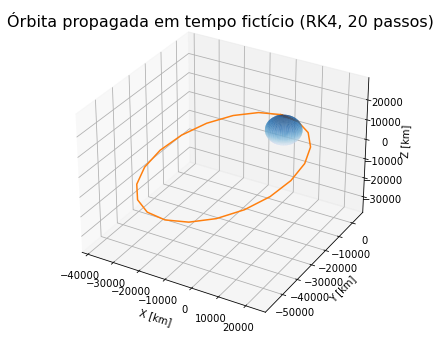

In [21]:
# Separando em 3 coordenadas os vetores posição resultados da integração
Xs = np.array(Xs_rk4)
xs1_rk4 = Xs[:, 0]
xs2_rk4 = Xs[:, 1]
xs3_rk4 = Xs[:, 2]
vxs1_rk4 = Xs[:, 3]
vxs2_rk4 = Xs[:, 4]
vxs3_rk4 = Xs[:, 5]
plotar_orbita_terra(xs1_rk4, xs2_rk4, xs3_rk4, titulo = 'Órbita propagada em tempo fictício (RK4, 20 passos)')

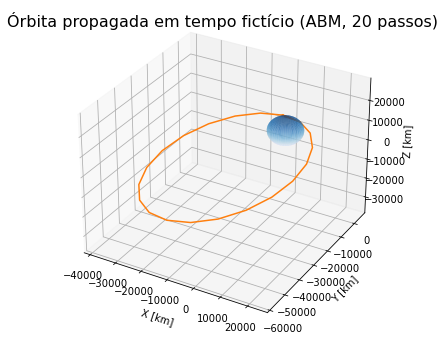

In [22]:
# Separando em 3 coordenadas os vetores posição resultados da integração
Xs = np.array(Xs_abm)
xs1_abm = Xs[:, 0]
xs2_abm = Xs[:, 1]
xs3_abm = Xs[:, 2]
vxs1_abm = Xs[:, 3]
vxs2_abm = Xs[:, 4]
vxs3_abm = Xs[:, 5]
plotar_orbita_terra(xs1_abm, xs2_abm, xs3_abm, titulo = 'Órbita propagada em tempo fictício (ABM, 20 passos)')

## Comparando com resultados exatos no tempo final

O período de uma órbita pode ser determinado a partir de seu semieixo maior pela equação:

\begin{equation}
T = 2 \pi \frac{a^{3/2}}{\mu^{1/2}} 
\end{equation}

que retorna um valor de:

In [23]:
mu = 3.9860064e5
T = 2*pi*(a**(3/2)/mu**(1/2))
print(T, 's')

64799.997248798194 s


O valor final exato de posição e velocidade é dado por: 

* $x$ = 1888,98004 $km$,
* $y$ = 6652,20967 $km$,
* $z$ = 9024,8288 $km$,
* $v_x$ = -9,58580 $km/s$,
* $v_y$ =  2,41357 $km/s$ e
* $v_z$ =  2,27350 $km/s$.

Isso acontece em $t = 64.799,997248798194 \: s$. Os valores finais de integração não coincidem com o período da órbita, de forma que é necessário interpolar os resultados para obter dados quanto valem em $t = 64.799,997248798194 \:s$. O método de interpolação utilizado é o disponibilizado pela biblioteca Numpy e sua ordem, depois de alguns testes, foi escolhida como 6. Apenas o último terço dos resultados foi interpolado.

In [24]:
def interpolar(Ts, Xs, parcela, ordem):
    '''
    Função para interpolar cada componente de um vetor de estados
    que contenha posição e velocidade
    ---
    Entradas:
        Xs_rk4 = vetor de estados com nx6 elementos (n x (posição, velocidade))
        parcela = proporção dos dados, contados a partir do final, que será
                    interpolada
        ordem = ordem da interpolação
    '''
    
    # Conversão em array e captação
    Xs = np.array(Xs)
    xs1 = Xs[:, 0]
    xs2 = Xs[:, 1]
    xs3 = Xs[:, 2]
    vxs1 = Xs[:, 3]
    vxs2 = Xs[:, 4]
    vxs3 = Xs[:, 5]
    
    # Indexador
    m = int(parcela*len(Ts_rk4))
    
    # Valores para T = 64800 s do RK4
    x_p  = np.polynomial.polynomial.Polynomial.fit(Ts[-m:], xs1[-m:], deg = ordem)
    y_p  = np.polynomial.polynomial.Polynomial.fit(Ts[-m:], xs2[-m:], deg = ordem)
    z_p  = np.polynomial.polynomial.Polynomial.fit(Ts[-m:], xs3[-m:], deg = ordem)
    vx_p = np.polynomial.polynomial.Polynomial.fit(Ts[-m:], vxs1[-m:], deg = ordem)
    vy_p = np.polynomial.polynomial.Polynomial.fit(Ts[-m:], vxs2[-m:], deg = ordem)
    vz_p = np.polynomial.polynomial.Polynomial.fit(Ts[-m:], vxs3[-m:], deg = ordem)
    
    return x_p, y_p, z_p, vx_p, vy_p, vz_p

In [25]:
def resultado_interpolado(x_p, y_p, z_p, vx_p, vy_p, vz_p, w):
    '''
    Esta função calcula o valor de um ajuste de dados interpolados 
    a partir dos coeficientes armazenados em p e do índice no qual
    a interpolação será avaliada w
    '''
    x = x_p(w) 
    y = y_p(w) 
    z = z_p(w) 
    vx = vx_p(w) 
    vy = vy_p(w) 
    vz = vz_p(w) 
    
    return x, y, z, vx, vy, vz

In [26]:
# Interpolação para os resultados do RK4
x_p_rk4, y_p_rk4, z_p_rk4, vx_p_rk4, vy_p_rk4, vz_p_rk4 = interpolar(Ts_rk4, Xs_rk4, 1/3, 6)

# Interpolação para os resultados do ABM
x_p_abm, y_p_abm, z_p_abm, vx_p_abm, vy_p_abm, vz_p_abm = interpolar(Ts_abm, Xs_abm, 1/3, 6)

# Valores para T = 64800 s do RK4 com RK4
x_p_rk4, y_p_rk4, z_p_rk4, vx_p_rk4, vy_p_rk4, vz_p_rk4 = resultado_interpolado(x_p_rk4, 
                                                                               y_p_rk4, 
                                                                               z_p_rk4,
                                                                               vx_p_rk4,
                                                                                vy_p_rk4, 
                                                                                vz_p_rk4, 
                                                                                64799.997248798194)
# Valores para T = 64800 s do ABM
x_p_abm, y_p_abm, z_p_abm, vx_p_abm, vy_p_abm, vz_p_abm = resultado_interpolado(x_p_abm, 
                                                                                y_p_abm, 
                                                                                z_p_abm,
                                                                                vx_p_abm,
                                                                                vy_p_abm, 
                                                                                vz_p_abm, 
                                                                                64799.997248798194)  

Abaixo, os valores para comparação são plotados e mostrados em um dataframe.

In [27]:
# Montando as listas com os dados
rk4_lista = [x_p_rk4, y_p_rk4, z_p_rk4, 
             vx_p_rk4*1000, vy_p_rk4*1000, vz_p_rk4*1000]

abm_lista = [x_p_abm, y_p_abm,  z_p_abm, 
             vx_p_abm*1000, vy_p_abm*1000, vz_p_abm*1000]

res = [1888.98004, 6652.20967, 902.48288, 
       -9.58580*1000, 2.41357*1000, 2.27350*1000]

# Criando o dataframe
df = pd.DataFrame({'Resultados Exatos' : res, 
                   'RK4' : rk4_lista, 
                   'ABM' : abm_lista}, index = ['$x [km]$', '$y [km]$', '$z [km]$', 
                                                '$v_x [m/s]$', '$v_y [m/s]$', '$v_z [m/s]$'])

# Calculando as magnitudes de posição e velocidade
df.loc['R [km]'] = (df.loc['$x [km]$']**2 
                    + df.loc['$y [km]$']**2 
                    + df.loc['$z [km]$']**2)**(1/2)

df.loc['V [km/s]'] = ((df.loc['$v_x [m/s]$']**2 
                       + df.loc['$v_y [m/s]$']**2 
                       + df.loc['$v_z [m/s]$']**2)**(1/2))/1000

# Erros dos integradores
df['Erro do RK4 [%]'] = np.round(100*(df['Resultados Exatos'] - df['RK4'])/df['Resultados Exatos'], 4)
df['Erro do ABM [%]'] = np.round(100*(df['Resultados Exatos'] - df['ABM'])/df['Resultados Exatos'], 4)

#df.plot(kind = 'bar', figsize = (8, 4))
#plt.grid()

display(df)

,Resultados Exatos,RK4,ABM,Erro do RK4 [%],Erro do ABM [%]
$x [km]$,1888.980040,3158.735024,4185.734447,-67.2191,-121.5870
$y [km]$,6652.209670,6206.231892,5899.872932,6.7042,11.3096
$z [km]$,902.482880,577.405242,324.775575,36.0204,64.0131
$v_x [m/s]$,-9585.800000,-9078.664339,-8558.299587,5.2905,10.7190
$v_y [m/s]$,2413.570000,3362.921319,4061.855018,-39.3339,-68.2924
$v_z [m/s]$,2273.500000,2357.290948,2391.124173,-3.6855,-5.1737
R [km],6973.852195,6987.726244,7241.156859,-0.1989,-3.8330
V [km/s],10.143061,9.964347,9.770396,1.7619,3.6741


A tabela acima mostra os resultados para 20 divisões do valor final de $s$. Comparando os resultados escalares exatos com os dos integradores, erros da ordem de 30%, 40%, 60%, 70% e até 120% podem ser encontrados. Entretanto, calculando os erros das magnitudes de posição e velocidade, os valores integrados numericamente ficam menores que 4% distantes dos teóricos.

## Melhorando os resultados reduzindo o tamanho do passo

Abaixo, o código construído acima é replicado para dividir o valor final de tempo fictício mais vezes que apenas 20. A ideia é testar a qualidade dos resultados quando mais passos de integração são utilizados.

In [28]:
def gerar_comparacao(N):
    
    # Estado inicial
    r = np.array([1888.98004103698, 6652.20967475597, 902.482883545056])
    v = np.array([-9.58579511076297, 2.41357051166562, 2.27350409709003])
    
    # Elementos orbitais
    a, e, i, Omega, omega, f = elementos_keplerianos(r, v)  
    
    # Período
    mu = 3.9860064e5
    T = 2*pi*(a**(3/2)/mu**(1/2))
    
    # Configurações inciais
    s0 = 0.
    sf = 2*np.pi*np.sqrt(a/mu)
    hs = (sf - s0)/N
    r_norm = np.linalg.norm(r)
    vs = v*r_norm
    H0 = mu/(2*a)
    xs0 = np.concatenate((r, vs, np.array([H0]), np.array([s0])), axis = None)
    
    # Integradores
    rk = RungeKutta()
    ts_rk4, xs_rk4 = rk.integrador(eq = eq_s,   metodo = rk.rk4, t0 = s0,
                                   tf = sf, x0 = xs0, h = hs)
    
    abm = AdamsBashforthMoulton()
    ts_abm, xs_abm = abm.preditor_corretor(eq = eq_s, metodo = abm.rk4, t0 = s0,
                                           tf = sf, x0 = xs0, h = hs)
    
    # Transformação da velocidade
    Ts_rk4, Xs_rk4 = vs2vt(xs_rk4)
    Ts_abm, Xs_abm = vs2vt(xs_abm)
    
    # Interpolação para os resultados do RK4
    x_p_rk4, y_p_rk4, z_p_rk4, vx_p_rk4, vy_p_rk4, vz_p_rk4 = interpolar(Ts_rk4, Xs_rk4, 1/3, 6)
    
    # Interpolação para os resultados do ABM
    x_p_abm, y_p_abm, z_p_abm, vx_p_abm, vy_p_abm, vz_p_abm = interpolar(Ts_abm, Xs_abm, 1/3, 6)

    # Valores para T = 64800 s do RK4 com RK4
    x_p_rk4, y_p_rk4, z_p_rk4, vx_p_rk4, vy_p_rk4, vz_p_rk4 = resultado_interpolado(x_p_rk4, 
                                                                                   y_p_rk4, 
                                                                                   z_p_rk4,
                                                                                   vx_p_rk4,
                                                                                    vy_p_rk4, 
                                                                                    vz_p_rk4, 
                                                                                    64799.997248798194)
    # Valores para T = 64800 s do ABM
    x_p_abm, y_p_abm, z_p_abm, vx_p_abm, vy_p_abm, vz_p_abm = resultado_interpolado(x_p_abm, 
                                                                                    y_p_abm, 
                                                                                    z_p_abm,
                                                                                    vx_p_abm,
                                                                                    vy_p_abm, 
                                                                                    vz_p_abm, 
                                                                                    64799.997248798194)   
       
    # Montando as listas com os dados
    rk4_lista = [x_p_rk4, y_p_rk4, z_p_rk4, 
                 vx_p_rk4*1000, vy_p_rk4*1000, vz_p_rk4*1000]

    abm_lista = [x_p_abm, y_p_abm,  z_p_abm, 
                 vx_p_abm*1000, vy_p_abm*1000, vz_p_abm*1000]

    res = [1888.98004, 6652.20967, 902.48288, 
           -9.58580*1000, 2.41357*1000, 2.27350*1000]

    # Criando o dataframe
    df = pd.DataFrame({'Resultados Exatos' : res, 
                       'RK4' : rk4_lista, 
                       'ABM' : abm_lista}, index = ['$x [km]$', '$y [km]$', '$z [km]$', 
                                                    '$v_x [m/s]$', '$v_y [m/s]$', '$v_z [m/s]$'])
    
    # Calculando as magnitudes de posição e velocidade
    df.loc['R [km]'] = (df.loc['$x [km]$']**2 
                        + df.loc['$y [km]$']**2 
                        + df.loc['$z [km]$']**2)**(1/2)
    
    df.loc['V [km/s]'] = ((df.loc['$v_x [m/s]$']**2 
                           + df.loc['$v_y [m/s]$']**2 
                           + df.loc['$v_z [m/s]$']**2)**(1/2))/1000
    
    # Erros dos integradores
    df['Erro do RK4 [%]'] = np.round(100*(df['Resultados Exatos'] - df['RK4'])/df['Resultados Exatos'], 4)
    df['Erro do ABM [%]'] = np.round(100*(df['Resultados Exatos'] - df['ABM'])/df['Resultados Exatos'], 4)
    
    # Prints
    print('-------------------------------------------------------------------------')
    print('Comparação para N =', N, 'passos do tempo fictício')

    #df.plot(kind = 'bar', figsize = (8, 4))
    #plt.grid()
    #plt.title('Comparação para N = ' + str(N) + ' passos do tempo fictício')
    display(df)

Abaixo, a função acima é rodada para as seguintes divisões do intervalo de integração: 50, 100, 400 e 800.

In [29]:
_ = [gerar_comparacao(N) for N in [50, 100, 400, 800]]

-------------------------------------------------------------------------
Comparação para N = 50 passos do tempo fictício


,Resultados Exatos,RK4,ABM,Erro do RK4 [%],Erro do ABM [%]
$x [km]$,1888.980040,1920.844643,1944.750961,-1.6869,-2.9524
$y [km]$,6652.209670,6644.127141,6639.673611,0.1215,0.1884
$z [km]$,902.482880,894.914152,889.540849,0.8387,1.4340
$v_x [m/s]$,-9585.800000,-9578.343542,-9572.126294,0.0778,0.1426
$v_y [m/s]$,2413.570000,2439.720719,2458.752237,-1.0835,-1.8720
$v_z [m/s]$,2273.500000,2277.046904,2279.474807,-0.1560,-0.2628
R [km],6973.852195,6973.875605,6975.572011,-0.0003,-0.0247
V [km/s],10.143061,10.143069,10.142340,-0.0001,0.0071


-------------------------------------------------------------------------
Comparação para N = 100 passos do tempo fictício


,Resultados Exatos,RK4,ABM,Erro do RK4 [%],Erro do ABM [%]
$x [km]$,1888.980040,1890.968176,1890.509617,-0.1052,-0.0810
$y [km]$,6652.209670,6651.708056,6651.880575,0.0075,0.0049
$z [km]$,902.482880,902.011153,902.130723,0.0523,0.0390
$v_x [m/s]$,-9585.800000,-9585.335244,-9585.423587,0.0048,0.0039
$v_y [m/s]$,2413.570000,2415.192400,2414.789957,-0.0672,-0.0505
$v_z [m/s]$,2273.500000,2273.724264,2273.664752,-0.0099,-0.0072
R [km],6973.852195,6973.851506,6973.907201,0.0000,-0.0008
V [km/s],10.143061,10.143058,10.143032,0.0000,0.0003


-------------------------------------------------------------------------
Comparação para N = 400 passos do tempo fictício


,Resultados Exatos,RK4,ABM,Erro do RK4 [%],Erro do ABM [%]
$x [km]$,1888.980040,1888.987820,1888.979906,-0.0004,0.0000
$y [km]$,6652.209670,6652.207715,6652.209761,0.0000,-0.0000
$z [km]$,902.482880,902.481038,902.482926,0.0002,-0.0000
$v_x [m/s]$,-9585.800000,-9585.793310,-9585.795121,0.0001,0.0001
$v_y [m/s]$,2413.570000,2413.576856,2413.570368,-0.0003,-0.0000
$v_z [m/s]$,2273.500000,2273.504958,2273.504072,-0.0002,-0.0002
R [km],6973.852195,6973.852199,6973.852251,-0.0000,-0.0000
V [km/s],10.143061,10.143057,10.143057,0.0000,0.0000


-------------------------------------------------------------------------
Comparação para N = 800 passos do tempo fictício


,Resultados Exatos,RK4,ABM,Erro do RK4 [%],Erro do ABM [%]
$x [km]$,1888.980040,1888.980527,1888.979999,-0.0000,0.0000
$y [km]$,6652.209670,6652.209552,6652.209687,0.0000,-0.0000
$z [km]$,902.482880,902.482768,902.482894,0.0000,-0.0000
$v_x [m/s]$,-9585.800000,-9585.794998,-9585.795120,0.0001,0.0001
$v_y [m/s]$,2413.570000,2413.570908,2413.570477,-0.0000,-0.0000
$v_z [m/s]$,2273.500000,2273.504151,2273.504092,-0.0002,-0.0002
R [km],6973.852195,6973.852200,6973.852202,-0.0000,-0.0000
V [km/s],10.143061,10.143057,10.143057,0.0000,0.0000


As tabelas acima mostram que com o aumento do número de divisões feitas no tempo fictício total de integração, isto é, com o aumento de passos de integração, os resultados numéricos ficam cada vez mais próximos dos exatos.

## Comparação com o trabalho 1

No trabalho 1, desenvolvido antes deste, foram obtidos os resultados abaixo, tanto para o tempo físico quanto para o fictício. Esses resultados serão comparados com os obtidos neste trabalho.

In [30]:
# Resultados convencionais do trabalho 1

# Tempo
Ts_ref = np.array([    0.        ,   689.87296971,  1630.35394028,  3048.56808719,
                5125.93445442,  7980.89374864, 11657.47766193, 16121.08831454,
               21261.81310856, 26904.94509171, 32827.70191174, 38780.54407806,
               44511.05289738, 49788.08325684, 54423.87971744, 58292.038306  ,
               61339.59168763, 63592.05550346, 65150.9746593 , 66184.45402467,
               66911.49741571, 67578.07124493])

# Posição e velocidade
Xs_rk4_ref = np.array([[ 1.88898004e+03,  6.65220967e+03,  9.02482884e+02,
                        -9.58579511e+00,  2.41357051e+00,  2.27350410e+00],
                       [-4.68430241e+03,  6.56365190e+03,  2.13113518e+03,
                        -8.82449780e+00, -2.24911575e+00,  1.24582903e+00],
                       [-1.15533323e+04,  3.22699462e+03,  2.80040919e+03,
                        -5.93965140e+00, -4.26416068e+00,  3.17453035e-01],
                       [-1.80587969e+04, -3.04031572e+03,  2.84553197e+03,
                        -3.54755197e+00, -4.38515034e+00, -1.58698666e-01],
                       [-2.35764727e+04, -1.16373468e+04,  2.26209055e+03,
                        -1.97250865e+00, -3.87461484e+00, -3.60389570e-01],
                       [-2.75783760e+04, -2.17413434e+04,  1.10593494e+03,
                        -9.50145066e-01, -3.22892362e+00, -4.31757189e-01],
                       [-2.96816458e+04, -3.23855633e+04, -5.12307709e+02,
                        -2.62200387e-01, -2.59016634e+00, -4.41076662e-01],
                       [-2.96850668e+04, -4.25515782e+04, -2.43780108e+03,
                         2.20409180e-01, -1.98782472e+00, -4.18391186e-01],
                       [-2.75883324e+04, -5.12667030e+04, -4.48630988e+03,
                         5.70644340e-01, -1.41840449e+00, -3.76862478e-01],
                       [-2.35920788e+04, -5.76970669e+04, -6.46182745e+03,
                         8.29847827e-01, -8.69190468e-01, -3.21914562e-01],
                       [-1.80786897e+04, -6.12274039e+04, -8.17533039e+03,
                         1.02099732e+00, -3.24824470e-01, -2.54991092e-01],
                       [-1.15757084e+04, -6.15199231e+04, -9.46286497e+03,
                         1.15516147e+00,  2.31529243e-01, -1.74999390e-01],
                       [-4.70536091e+03, -5.85466272e+04, -1.02012342e+04,
                         1.23386950e+00,  8.18922830e-01, -7.86194027e-02],
                       [ 1.87498110e+03, -5.25919855e+04, -1.03197849e+04,
                         1.24825673e+00,  1.46023293e+00,  4.01628523e-02],
                       [ 7.53569722e+03, -4.42257085e+04, -9.80716578e+03,
                         1.17416045e+00,  2.18417875e+00,  1.91366846e-01],
                       [ 1.17351565e+04, -3.42482360e+04, -8.71241319e+03,
                         9.59840574e-01,  3.02650860e+00,  3.91568885e-01],
                       [ 1.40715350e+04, -2.36141913e+04, -7.14026523e+03,
                         4.98009776e-01,  4.02464234e+00,  6.68186456e-01],
                       [ 1.43213045e+04, -1.33412560e+04, -5.24118912e+03,
                        -4.34490148e-01,  5.18089315e+00,  1.06393932e+00],
                       [ 1.24610378e+04, -4.41348283e+03, -3.19719334e+03,
                        -2.27312331e+00,  6.29559723e+00,  1.62350426e+00],
                       [ 8.67104151e+03,  2.31278675e+03, -1.20469021e+03,
                        -5.53255551e+00,  6.41437835e+00,  2.26356992e+00],
                       [ 3.31190095e+03,  6.19815866e+03,  5.46855471e+02,
                        -9.12696108e+00,  3.53018723e+00,  2.39813332e+00],
                       [-3.09711686e+03,  6.86600546e+03,  1.88769974e+03,
                        -9.34040526e+00, -1.37110457e+00,  1.50993297e+00]])

# Resultados com a transformação de Sundman do trabalho 1

# Tempo
Tt_ref = np.array([    0.        ,  3239.99986244,  6479.99972488,  9719.99958732,
                   12959.99944976, 16199.9993122 , 19439.99917464, 22679.99903708,
                   25919.99889952, 29159.99876196, 32399.9986244 , 35639.99848684,
                   38879.99834928, 42119.99821172, 45359.99807416, 48599.9979366 ,
                   51839.99779904, 55079.99766148, 58319.99752392, 61559.99738636,
                   64799.9972488 , 68039.99711124])

# Posição e velocidade
Xt_rk4_ref = np.array([[ 1.88898004e+03,  6.65220967e+03,  9.02482884e+02,
                        -9.58579511e+00,  2.41357051e+00,  2.27350410e+00],
                       [-3.00948568e+04,  1.56609601e+02,  5.73170574e+03,
                        -8.69961026e+00, -2.31507663e+00,  1.20966923e+00],
                       [-5.68578765e+04, -7.29082717e+03,  9.39140396e+03,
                        -7.98447416e+00, -2.27312620e+00,  1.08212162e+00],
                       [-8.22580514e+04, -1.45877841e+04,  1.28213970e+04,
                        -7.72781218e+00, -2.23398592e+00,  1.04090807e+00],
                       [-1.07058724e+05, -2.17816867e+04,  1.61573286e+04,
                        -7.59347104e+00, -2.20841674e+00,  1.02029919e+00],
                       [-1.31517305e+05, -2.89068051e+04,  1.94414771e+04,
                        -7.51028739e+00, -2.19081500e+00,  1.00787347e+00],
                       [-1.55753369e+05, -3.59832962e+04,  2.26926788e+04,
                        -7.45352262e+00, -2.17802020e+00,  9.99542540e-01],
                       [-1.79832623e+05, -4.30236776e+04,  2.59210117e+04,
                        -7.41223384e+00, -2.16831197e+00,  9.93559012e-01],
                       [-2.03795194e+05, -5.00361999e+04,  2.91325154e+04,
                        -7.38081142e+00, -2.16069583e+00,  9.89048468e-01],
                       [-2.27667446e+05, -5.70265765e+04,  3.23311022e+04,
                        -7.35607484e+00, -2.15456115e+00,  9.85523989e-01],
                       [-2.51467652e+05, -6.39989238e+04,  3.55194545e+04,
                        -7.33608306e+00, -2.14951342e+00,  9.82692561e-01],
                       [-2.75209015e+05, -7.09563059e+04,  3.86994934e+04,
                        -7.31958282e+00, -2.14528666e+00,  9.80367121e-01],
                       [-2.98901392e+05, -7.79010646e+04,  4.18726428e+04,
                        -7.30572806e+00, -2.14169515e+00,  9.78422555e-01],
                       [-3.22552341e+05, -8.48350302e+04,  4.50399877e+04,
                        -7.29392656e+00, -2.13860531e+00,  9.76771969e-01],
                       [-3.46167786e+05, -9.17596607e+04,  4.82023745e+04,
                        -7.28375118e+00, -2.13591858e+00,  9.75353104e-01],
                       [-3.69752458e+05, -9.86761364e+04,  5.13604759e+04,
                        -7.27488595e+00, -2.13356068e+00,  9.74120168e-01],
                       [-3.93310199e+05, -1.05585426e+05,  5.45148361e+04,
                        -7.26709201e+00, -2.13147454e+00,  9.73038718e-01],
                       [-4.16844169e+05, -1.12488336e+05,  5.76659013e+04,
                        -7.26018542e+00, -2.12961560e+00,  9.72082347e-01],
                       [-4.40357000e+05, -1.19385542e+05,  6.08140421e+04,
                        -7.25402219e+00, -2.12794855e+00,  9.71230463e-01],
                       [-4.63850909e+05, -1.26277618e+05,  6.39595696e+04,
                        -7.24848797e+00, -2.12644504e+00,  9.70466769e-01],
                       [-4.87327780e+05, -1.33165057e+05,  6.71027475e+04,
                        -7.24349078e+00, -2.12508208e+00,  9.69778197e-01],
                       [-5.10789226e+05, -1.40048281e+05,  7.02438016e+04,
                        -7.23895578e+00, -2.12384077e+00,  9.69154146e-01]])

Para comparar os resultados, é preciso interpolá-los, para que os valores assumidos pela órbita após 1 período sejam obtidos. 

In [31]:
# Interpolação para os resultados do tempo físico
x_p_t, y_p_t, z_p_t, vx_p_t, vy_p_t, vz_p_t = interpolar(Tt_ref, Xt_rk4_ref, 1/3, 6)

# Interpolação para os resultados do tempo fictício
x_p_s, y_p_s, z_p_s, vx_p_s, vy_p_s, vz_p_s = interpolar(Ts_ref, Xs_rk4_ref, 1/3, 6)

# Valores para T = 64800 s do RK4 com RK4
x_p_t, y_p_t, z_p_t, vx_p_t, vy_p_t, vz_p_t = resultado_interpolado(x_p_t, 
                                                                    y_p_t, 
                                                                    z_p_t,
                                                                    vx_p_t,
                                                                    vy_p_t, 
                                                                    vz_p_t, 
                                                                    64799.997248798194)

# Valores para T = 64800 s do ABM
x_p_s, y_p_s, z_p_s, vx_p_s, vy_p_s, vz_p_s = resultado_interpolado(x_p_s, 
                                                                    y_p_s, 
                                                                    z_p_s,
                                                                    vx_p_s,
                                                                    vy_p_s, 
                                                                    vz_p_s, 
                                                                    64799.997248798194) 

# Listas de resultados do trabalho 1
lista_t_t1 = [x_p_t, y_p_t, z_p_t, vx_p_t, vy_p_t, vz_p_t]
lista_s_t1 = [x_p_s, y_p_s, z_p_s, vx_p_s, vy_p_s, vz_p_s]

# Corrigindo as unidades de velocidade
rk4_lista = [rk4_lista[0], rk4_lista[1], rk4_lista[2], 
             rk4_lista[3]/1000, rk4_lista[4]/1000, rk4_lista[5]/1000]
abm_lista = [abm_lista[0], abm_lista[1], abm_lista[2], 
             abm_lista[3]/1000, abm_lista[4]/1000, abm_lista[5]/1000]
res = [res[0], res[1], res[2], 
             res[3]/1000, res[4]/1000, res[5]/1000]
# Dataframe
df = pd.DataFrame({'RK4 - Convencional Trabalho 1 (CT1)' : lista_t_t1,
                   'RK4 - Sundman Trabalho 1 (ST1)' : lista_s_t1,
                   'RK4 - Sundman Estabilizado Trabalho 2 (SET2)' : rk4_lista,
                   'ABM - Sundman Estabilizado Trabalho 2 (SET2)' : abm_lista,
                   'Resultados Exatos' : res
                  },
                 index = ['$x [km]$', '$y [km]$', '$z [km]$', 
                          '$v_x [km/s]$', '$v_y [km/s]$', '$v_z [km/s]$'])

# Calculando as magnitudes de posição e velocidade
df.loc['R [km]'] = (df.loc['$x [km]$']**2 
                    + df.loc['$y [km]$']**2 
                    + df.loc['$z [km]$']**2)**(1/2)

df.loc['V [km/s]'] = ((df.loc['$v_x [km/s]$']**2 
                       + df.loc['$v_y [km/s]$']**2 
                       + df.loc['$v_z [km/s]$']**2)**(1/2))

# Erros dos integradores
df['(SET2-CT1)/SET2 | RK4'] = np.round(-(df['RK4 - Convencional Trabalho 1 (CT1)'] - \
                                      df['RK4 - Sundman Estabilizado Trabalho 2 (SET2)'])/\
                                       df['RK4 - Sundman Estabilizado Trabalho 2 (SET2)'], 4)

df['(SET2-ST1)/SET2 | RK4'] = np.round(-(df['RK4 - Sundman Trabalho 1 (ST1)'] - \
                                      df['RK4 - Sundman Estabilizado Trabalho 2 (SET2)'])/\
                                       df['RK4 - Sundman Estabilizado Trabalho 2 (SET2)'], 4)

df['(SET2-CT1)/SET2 | ABM'] = np.round(-(df['RK4 - Convencional Trabalho 1 (CT1)'] - \
                                      df['ABM - Sundman Estabilizado Trabalho 2 (SET2)'])/\
                                       df['ABM - Sundman Estabilizado Trabalho 2 (SET2)'], 4)

df['(SET2-ST1)/SET2 | ABM'] = np.round(-(df['RK4 - Sundman Trabalho 1 (ST1)'] - \
                                      df['ABM - Sundman Estabilizado Trabalho 2 (SET2)'])/\
                                       df['ABM - Sundman Estabilizado Trabalho 2 (SET2)'], 4)


df['(CT1-EXATOS)/EXATOS | RK4'] = np.round((df['RK4 - Convencional Trabalho 1 (CT1)'] - \
                                      df['Resultados Exatos'])/df['Resultados Exatos'], 4)

df['(ST1-EXATOS)/EXATOS | RK4'] = np.round((df['RK4 - Sundman Trabalho 1 (ST1)'] - \
                                      df['Resultados Exatos'])/df['Resultados Exatos'], 4)

df['(SET2-EXATOS)/EXATOS | RK4]'] = np.round((df['RK4 - Sundman Estabilizado Trabalho 2 (SET2)'] - \
                                      df['Resultados Exatos'])/df['Resultados Exatos'], 4)

df['(SET2-EXATOS)/EXATOS | ABM'] = np.round((df['ABM - Sundman Estabilizado Trabalho 2 (SET2)'] - \
                                      df['Resultados Exatos'])/df['Resultados Exatos'], 4)
df.T

,$x [km]$,$y [km]$,$z [km]$,$v_x [km/s]$,$v_y [km/s]$,$v_z [km/s]$,R [km],V [km/s]
RK4 - Convencional Trabalho 1 (CT1),-487327.780000,-133165.057000,67102.747500,-7.243491,-2.125082,0.969778,509631.314077,7.610821
RK4 - Sundman Trabalho 1 (ST1),13048.719614,-6587.638923,-3720.475151,-1.814632,5.794832,1.441755,15083.368507,6.241124
RK4 - Sundman Estabilizado Trabalho 2 (SET2),3158.735024,6206.231892,577.405242,-9.078664,3.362921,2.357291,6987.726244,9.964347
ABM - Sundman Estabilizado Trabalho 2 (SET2),4185.734447,5899.872932,324.775575,-8.558300,4.061855,2.391124,7241.156859,9.770396
Resultados Exatos,1888.980040,6652.209670,902.482880,-9.585800,2.413570,2.273500,6973.852195,10.143061
(SET2-CT1)/SET2 | RK4,155.279400,22.456700,-115.214300,0.202100,1.631900,0.588600,-71.932400,0.236200
(SET2-ST1)/SET2 | RK4,-3.131000,2.061500,7.443400,0.800100,-0.723200,0.388400,-1.158600,0.373700
(SET2-CT1)/SET2 | ABM,117.425900,23.570800,-205.612700,0.153600,1.523200,0.594400,-69.379800,0.221000
(SET2-ST1)/SET2 | ABM,-2.117400,2.116600,12.455500,0.788000,-0.426600,0.397000,-1.083000,0.361200
(CT1-EXATOS)/EXATOS | RK4,-258.984600,-21.018200,73.353500,-0.244400,-1.880500,-0.573400,72.077400,-0.249700


Os resultados comparados entre o trabalho 2 (T2) e o trabalho 1 (T1) foram tabulados acima. A nomenclatura para o método de integração é dada por "SE" = "Sundman estabilizado", "C" = "convencional" (integração no tempo físico), "EXATOS" = "resultados exatos". No trabalho 1, a integração numérica realizada com o RK4 gerou resultados que não convergiram. O passo de integração era grande demais para o problema, pois foi calculado dividido o período por 20. É desnecessária a utilização desses resultados na comparação. Os demais resultados são comparados por:

* (SET2-ST1)/SET2 | RK4. Esse cálculo compara a diferença entre o STE2 e o ST1 com relação ao STE2, integrados com o RK4 no trabalho 2 e com o RK4 no trabalho 1. Em termos absolutos, os erros de posição são pelo menos de 2 e no máximo 7,5. Os erros de velocidade sao de pelo menos 0,38 e no máximo de 0,8, aproximadamente. 

* (SET2-ST1)/SET2 | ABM. Esse cálculo compara a diferença entre o STE2 e o ST1 com relação ao STE2, integrados com o ABM no trabalho 2 e com o RK4 no trabalho 1. Em termos absolutos, os erros de posição são pelo menos de 2 e no máximo 12. Os erros de velocidade sao de pelo menos 0,4 e no máximo de 0,8, aproximadamente. 

* O cálculo (ST1-EXATOS)/EXATOS, no qual o ST1 foi calculado com o RK4, o erro proporcional máximo é de quase 6 e o mínimo é de quase 2 para a  poisição, em termos absolutos. Para a velocidade, é de quase 0,35 o mínimo e quase 1,4 o máximo.

* O cálculo (SET2-EXATOS)/EXATOS, no qual o ST2 foi calculado com o RK4, o erro proporcional máximo é de quase 0,7 e o mínimo é de quase 0,07 para a  poisição, em termos absolutos. Para a velocidade, é de quase 0,04 o mínimo e quase 0,4 o máximo.

* O cálculo (SET2-EXATOS)/EXATOS, no qual o ST2 foi calculado com o ABM, o erro proporcional máximo é de quase 1,2 e o mínimo é de quase 0,1 para a  poisição, em termos absolutos. Para a velocidade, é de quase 0,05 o mínimo e quase 0,7 o máximo.

* Analisando os valores em termos das magnitudes de posição e velocidade, valores mais suaves que os citados acima podem ser encontrados.

Vale lembrar que a divisão do tempo fictício final foi por 20 nos casos citados acima. Aumentar esse denominador melhora os resultados, como mostrado na seção anterior. Comparando o trabalho 1 e o trabalho 2, a integração numérica ficou ligeiramente melhor com o ABM que com o RK4. Em termos de exatidão, o RK4 foi melhor que o ABM.

## Referências

KUGA, H. Notas de Aula da Disciplina Satélites Artificiais -  Movimento Orbital. Capítulo 6 - Métodos de Integração de Órbita. Instituto Nacional de Pesquisas Espaciais. 2021.

FERNANDES, S. ZANARDI, C. Fundamentos de Astronáutica. Editora UFABC, 1ed, Vol. 2. 2018.

FRANCO, N. Cálculo Numérico. Pearson Universidades. 1 ed. 2006.

HOFFMAN, J. Numerical Methods for Engineers and Scientists. Purdue University. 1 ed. 1992.

CURTIS, H. Orbital Mechanics for Engineering Students. Elsevier. 4 ed. 2020.